In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, scale, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Подготовка путей

In [70]:
src_path = Path('.').absolute().parents[0]
sys.path.insert(0, f'{src_path}')
sys.path[0]

'/Users/sitd1/0_python_projects/danyad/src'

# Чтение файла

In [71]:
data_folder = src_path / 'data'

In [72]:
df = pd.read_csv(data_folder / 'data.csv', sep=';')

In [73]:
print(df.shape)
df.head(2)

(84, 18)


,Z1,Z2,X1,X2,X3,X4,X5,X6,X7,Z3,Z4,Z5,Z6,X8,Z7,Z8,X9,Y
0,Ж,Гастрошунтирование,52.021918,4.619178,45.724737,40.771224,30.483158,3500,25.529645,3,Да,Да,Да,9.136986,Нет,Комбинированная терапия без инсулина,0.075,0.059
1,Ж,Гастрошунтирование,52.046575,4.871233,45.785640,44.953174,29.136316,2100,27.887617,2,Да,Да,Да,2.238356,Нет,Монотерапия без инсулина,0.065,0.059


# Предподготовка переменных

In [153]:
random_seed = 6
# random_seed = None
target_name = 'Y'
excluded_columns = ['Z3', 'Z7']
features = df.columns.drop(target_name).difference(excluded_columns)
features_categorical = [el for el in features if 'z' in el.lower()]
features_numerical = features.difference(features_categorical)

# Подготовка данных

In [177]:
X = df[features]
y = df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_seed, test_size=0.05)

In [178]:
X_valid = X_train.sample(5)
y_valid = y_train.loc[X_valid.index]

In [179]:
X_train = X_train.loc[X_train.index.difference(X_valid.index)]
y_train = y_train.loc[y_train.index.difference(y_valid.index)]

In [180]:
X.isna().any().any()

False

In [181]:
X_train.shape

(74, 15)

In [182]:
y_valid.shape

(5,)

In [183]:
y_test.shape

(5,)

In [184]:
df.shape

(84, 18)

# Подготовка к обучению

In [172]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_numerical),
        ('cat', OneHotEncoder(), features_categorical)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', Ridge())])

# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1],
}

In [173]:

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'regressor__alpha': 0.001}
Best score found:  nan


/Users/sitd1/Library/Caches/pypoetry/virtualenvs/danyad-IgEVFd02-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sitd1/Library/Caches/pypoetry/virtualenvs/danyad-IgEVFd02-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sitd1/Library/Caches/pypoetry/virtualenvs/danyad-IgEVFd02-py3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sitd1/Library/Caches/pypoetry/virtualenvs/danyad-IgEVFd02-py

In [186]:
best_model = grid_search.best_estimator_

In [187]:
pred_vals = best_model.predict(X_test)

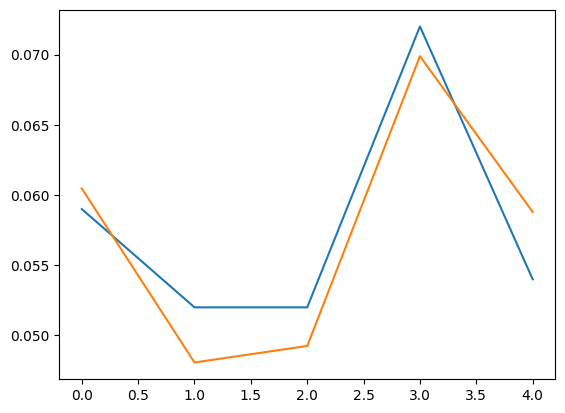

In [188]:
sns.lineplot(y_test.values)
sns.lineplot(pred_vals)
plt.show()

In [189]:
pred_valid_vals = best_model.predict(X_valid)

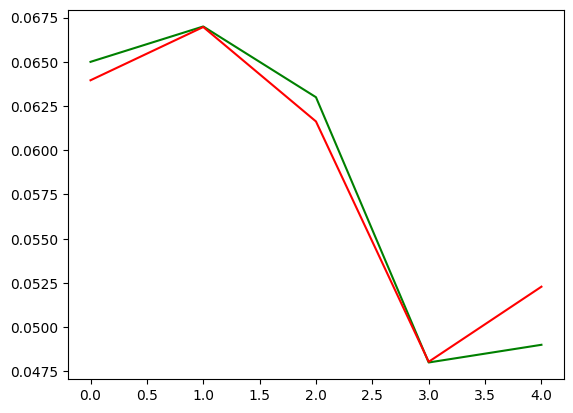

In [193]:
sns.lineplot(y_valid.values, color='green')
sns.lineplot(pred_valid_vals, color='red')
plt.show()

In [192]:
all_pred_vall = best_model.predict(X)

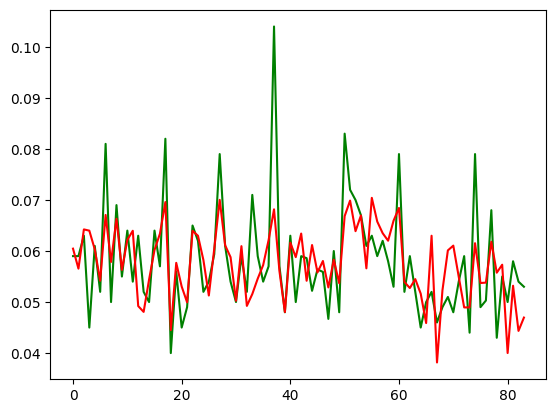

In [194]:
sns.lineplot(y.values, color='green')
sns.lineplot(all_pred_vall, color='red')
plt.show()

In [198]:
res = pd.DataFrame({
    'orig_vals': y,
    'pred_vals': dict(zip(y.index, all_pred_vall))
})

In [202]:
res['abs_error'] = abs(res['orig_vals'] - res['pred_vals'])
res['ape'] = abs(res['orig_vals'] - res['pred_vals'] / res['orig_vals'])
res['se'] = (res['orig_vals'] - res['pred_vals'])**2

In [207]:
res['cat_true'] = np.where(res['orig_vals']>=0.065, 1, 0)
res['cat_pred'] = np.where(res['pred_vals']>=0.065, 1, 0)

In [216]:
lin_reg_accuracy = (res.shape[0] - (res['cat_true'] != res['cat_pred']).sum()) / res.shape[0]

In [217]:
lin_reg_accuracy

0.9047619047619048

In [220]:
with open()
    best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9'], dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  ['Z1', 'Z2', 'Z4', 'Z5', 'Z6',
                                                   'Z8'])])),
                ('regressor', Ridge(alpha=0.001))])

In [221]:
import pickle

# Сохранение лучшей модели в файл pickle
with open('best_model_20240504_lin_reg_ridge_0_9047.pkl', 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)


# Логистическая регрессия

In [218]:
df2 = df.copy()
df2['Y_cat'] = np.where(df2['Y']>=0.065, 1, 0)

In [219]:
target_name_2 = 'Y_cat'